In [7]:
!pip install trimesh

In [17]:
#importing Libraries
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import heapq
import numpy as np
import copy
import math

#Create Class for half-edge implementation
class Vertex:
    def __init__(self, position):
        self.position = position
        self.half_edge = None

    def half_edge_iter(self):
        current_edge = self.half_edge
        if current_edge is None:
            return  # Early exit if there's no half-edge assigned to this vertex

        start_edge = current_edge
        while True:
            yield current_edge
            # Safely access `current_edge` attributes with checks for `None`
            if current_edge.pair and current_edge.pair.next:
                current_edge = current_edge.pair.next
                if current_edge == start_edge or current_edge is None:
                    break
            else:
                # Exit the loop if we encounter a boundary edge without a pair
                break



class HalfEdge:
    def __init__(self):
        self.vertex = None
        self.pair = None
        self.next = None
        self.face = None
        self.edge = None

    def set_next(self, next_edge):
        self.next = next_edge


    def set_pair(self, pair_edge):
        self.pair = pair_edge

class Face:
    def __init__(self):
        self.half_edge = None

class Edge:
    def __init__(self, he1=None, he2=None):
        self.halfedge1 = he1  # One of the half-edges of the edge
        self.halfedge2 = he2  # The other half-edge of the edge
        self.isNew = False  # Flag to indicate if this is a new edge
        self.newPosition = None  # new position of the point after subdivision

# Mesh implementation
class Mesh:
    def __init__(self):
        self.vertices = None
        self.faces = None
        self.edges = None
    # export vertices and faces for obj
    def export(self, filename):
        with open(filename, 'w') as file:
            for vertex in self.vertices:
                file.write(f"v {' '.join(map(str, vertex))}\n")

            for face in self.faces:
                # Add 1 to each vertex index
                file.write(f"f {' '.join(map(lambda x: str(x + 1), face))}\n")

#Custom load function to read obj files (reads vertices and faces)
def load(filename):
    mesh = Mesh()
    vertices = []
    faces = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('v '):
                vertex = list(map(float, line.strip().split()[1:]))
                vertices.append(vertex)
            elif line.startswith('f'):
                face = [int(vertex.split('/')[0])-1 for vertex in line.strip().split()[1:]]
                faces.append(face)
    mesh.vertices = vertices
    mesh.faces = faces
    return mesh

#function to plot mesh
def plot_original_and_operated_mesh(original_mesh, subdivided_mesh):
    fig = plt.figure()

    # Plot original mesh
    ax = fig.add_subplot(121, projection='3d')
    ax.set_title('Original Mesh')
    ax.scatter(original_mesh.vertices[:, 0], original_mesh.vertices[:, 1], original_mesh.vertices[:, 2], c='b', marker='.')

    # Plot operated mesh
    ax = fig.add_subplot(122, projection='3d')
    ax.set_title('Operated Mesh')
    ax.scatter(subdivided_mesh.vertices[:, 0], subdivided_mesh.vertices[:, 1], subdivided_mesh.vertices[:, 2], c='r', marker='.')

    plt.show()

#Plot mesh in 3d with faces
def plot_mesh(vertices, faces):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract x, y, z coordinates of vertices
    x = vertices[:, 0]
    y = vertices[:, 1]
    z = vertices[:, 2]

    # Plot vertices
    ax.scatter(x, y, z, c='r', marker='o')

    # Plot triangles by connecting vertices
    for face in faces:
        # Extract indices of vertices for this face
        idx1, idx2, idx3 = face

        # Get coordinates of vertices for this face
        x_tri = [x[idx1], x[idx2], x[idx3], x[idx1]]
        y_tri = [y[idx1], y[idx2], y[idx3], y[idx1]]
        z_tri = [z[idx1], z[idx2], z[idx3], z[idx1]]

        # Plot triangle
        ax.plot(x_tri, y_tri, z_tri, 'b-')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# half edge data structure implementation function
def build_half_edge_structure(vertices, faces):
    """
    param: vertices and faces
    This function builds the half edge structure for the given mesh using vertices and faces.
    return: vertex_objects, half_edges, face_objects, edges
    """
    vertex_objects = [Vertex(np.array(position)) for position in vertices]
    half_edges = []
    face_objects = [Face() for _ in range(len(faces))]
    edge_dict = {}  # To track edges and avoid duplicates
    edges = []  # Store Edge objects

    for i, face in enumerate(faces):
        face_half_edges = []  # Keep track of half-edges for this face
        for j in range(3):
            v_start = face[j]
            v_end = face[(j + 1) % 3]
            edge_key = (v_start, v_end)  # Use directed edge key for uniqueness

            if edge_key in edge_dict:
                half_edge = edge_dict[edge_key]
            else:
                half_edge = HalfEdge()
                half_edges.append(half_edge)
                edge_dict[edge_key] = half_edge
                half_edge.face = set(face)
                half_edge.vertex = vertex_objects[v_start]

                # When a new half-edge is created, link it back to its starting vertex
                vertex_objects[v_start].half_edge = half_edge

                # Check and link the pair edge
                pair_key = (v_end, v_start)
                if pair_key in edge_dict:
                    pair_half_edge = edge_dict[pair_key]
                    half_edge.set_pair(pair_half_edge)
                    pair_half_edge.set_pair(half_edge)

                    # Create and link Edge object
                    edge = Edge(half_edge, pair_half_edge)
                    edges.append(edge)
                    half_edge.edge = edge
                    pair_half_edge.edge = edge

            face_half_edges.append(half_edge)  # Add to this face's half-edges list

        # Set next for each half-edge in the face
        for k in range(3):
            face_half_edges[k].set_next(face_half_edges[(k + 1) % 3])

        # Link face to one of its half-edges
        face_objects[i].half_edge = face_half_edges[0]

    return vertex_objects, half_edges, face_objects, edges

# ------------------------------------------------------------------ helper functions for loop subdivision ----------------------------------------------

def compute_new_vertex_position(vertex):
    """
    input: vertex
    Compute the new position for an existing vertex using Loop's subdivision rules. (for even vertices)
    return: new position
    """
    # Dynamically calculate the number of adjacent vertices using half edge iter
    k = len(list(vertex.half_edge_iter()))
    n = len(list(vertex.half_edge_iter()))
    # print(n) # Correctly determine 'n' based on actual connectivity
    # beta = 3.0 / (8 * n) if n > 3 else 3.0 / 16.0  # Loop's formula for beta
    beta = (1/k) * (5/8 - (3/8 + 1/4 * math.cos(2 * math.pi / k)) ** 2)

    # Sum the positions of all adjacent vertices
    sum_adjacent = sum(he.next.vertex.position for he in vertex.half_edge_iter())
    # print(sum_adjacent)

    # Compute the new vertex position
    new_pos = (1 - n * beta) * vertex.position + beta * sum_adjacent
    return new_pos

def compute_new_edge_position(edge):
    """
    Compute the new position of an edge using Loop's subdivision rules. (for odd vertices)
    """
    # Access the positions of the two vertices of the edge
    v1 = edge.halfedge1.vertex.position  # access start vertex of the first half-edge
    v2 = edge.halfedge2.vertex.position  # access the start vertex of the pair half-edge
    # print(v1)

    # Check if the edge is a boundary edge by inspecting its faces
    if edge.halfedge1 is None or edge.halfedge2 is None:
        # print("hey")
        new_pos = (v1 + v2) / 2.0  # compute the midpoint if boundary edge
    else:
        # find the opposite vertices (v3 and v4) for interior edges
        v3 = edge.halfedge1.next.next.vertex.position
        v4 = edge.halfedge2.next.next.vertex.position

        # Apply Loop's rule for interior edges
        new_pos = (3.0 / 8.0) * (v1 + v2) + (1.0 / 8.0) * (v3 + v4)
        # print(new_pos)

    return new_pos

def subdivide_face(face, edge_to_new_vertex_map,face_new,vertex_set,i):
    """
    param: face object, edge_to_new_vertex_map(each edge and its new associated vertex)
    Creates a subdivided list of faces and vertices that are generated using loop subdivision
    return: new vertex and face list (with subdivided parameters)
    """
    # Start with half-edge associated with face
    start_edge = face.half_edge
    current_edge = start_edge
    j=i

    # Collect vertices for the new faces
    new_face_vertices = []

    while True:
        # Each edge gives us one new vertex (midpoint if boundary edge else loop formula used)
        new_vertex = edge_to_new_vertex_map[current_edge.edge]
        if new_vertex is not None:
            new_face_vertices.append(new_vertex)
        # Move to the next edge in the same face
        current_edge = current_edge.next

        if current_edge == start_edge:
          break
    # print(len(new_face_vertices))

    #keep appending new vertices ---> this is vertices for subdivided mesh
    vertex_set.append(start_edge.vertex.newPosition)
    vertex_set.append(new_face_vertices[0].position)
    vertex_set.append(new_face_vertices[2].position)
    vertex_set.append(new_face_vertices[1].position)
    vertex_set.append(start_edge.next.vertex.newPosition)
    # print(i)
    vertex_set.append(start_edge.next.next.vertex.newPosition)

    # these are faces of new subdivided mesh
    face_new.append([j*6+1,j*6+2, j*6])
    face_new.append([j*6+1,j*6+3, j*6+2])
    face_new.append([j*6+1,j*6+4,j*6+3])
    face_new.append([j*6+5,j*6+2,j*6+3])

    return vertex_set,face_new

# --------------------------------------------------------------------------subdivison loop----------------------------------------------------

def subdivision_loop(mesh, iterations=3):
    """
    Apply Loop subdivision to the input mesh for the specified number of iterations.
    :param mesh: input mesh
    :param iterations: number of iterations
    :return: mesh after subdivision
    """
    for _ in range(iterations):
        # build half edge data structure for mesh
        vertex_objects, half_edges, face_objects, edges = build_half_edge_structure(mesh.vertices, mesh.faces)
        edge_to_new_vertex_map = {}

        # Update the isNew flag and compute new positions for original vertices
        for vertex in vertex_objects:
            vertex.isNew = False
            vertex.newPosition = compute_new_vertex_position(vertex)
            # vertex.position = vertex.newPosition

        # for vertex in vertex_objects:
        #   print(vertex.position)

        new_face_objects = copy.copy(face_objects)


        # Compute new positions for edge midpoints and create new vertices
        for edge in edges:
            if not edge.isNew:
                new_vertex_position = compute_new_edge_position(edge)
                new_vertex = Vertex(new_vertex_position)
                new_vertex.isNew = True #set isNew to True
                vertex_objects.append(new_vertex)
                edge.newPosition = new_vertex_position
                edge_to_new_vertex_map[edge] = new_vertex # create a map of edge and its new vertex (odd vertices)

        # print(len(edge_to_new_vertex_map))
        i = 0
        vertex_set = []
        face_new = []
        # print(len(new_face_objects))
        # print("olf face", len(face_objects))

        # Subdivide each face (Iterate through each face and subdivide the mesh)
        for face in new_face_objects:
            vertex_updated,face_updated = subdivide_face(face, edge_to_new_vertex_map,face_new,vertex_set,i)
            vertex_set = vertex_updated # this is subdivided vertex positions
            face_new = face_updated # this is subdivided face positions
            i = i+1

        for vertex in vertex_objects:
            if vertex.isNew == False:
                vertex.position = vertex.newPosition
        # for vertex in vertex_objects:
        #     print(vertex.position)

        mesh = trimesh.Trimesh(vertices=np.array(vertex_set), faces=np.array(face_new))

    return mesh

# ---------------------------------------------------------- helper functions for quadric error decimation --------------------------------

def compute_plane_normal(v1, v2, v3):
    """
    param: v1,v2,v3 coordinates of each face
    This function computes the plane normal
    return: array a,b,c,d (p)
    """

    # make vectors
    v1v2 = (v2[0] - v1[0], v2[1] - v1[1], v2[2] - v1[2])
    v1v3 = (v3[0] - v1[0], v3[1] - v1[1], v3[2] - v1[2])

    # Calculate the normal vector
    # normal = (v1v2[1]*v1v3[2] - v1v2[2]*v1v3[1],
    #           -(v1v2[0]*v1v3[2] - v1v2[2]*v1v3[0]),
    #           v1v2[0]*v1v3[1] - v1v2[1]*v1v3[0])
    normal = np.cross(v1v2,v1v3)

    # Find coefficients a, b, c, and d
    a, b, c = normal
    coefficients = np.array([a, b, c])
    coefficients = coefficients / np.linalg.norm(coefficients) # Normalize coefficients (normal vector)
    d = -(coefficients[0]*v1[0] + coefficients[1]*v1[1] + coefficients[2]*v1[2])

    #
    coefficients1 = np.array([[coefficients[0], coefficients[1], coefficients[2], d]])

    return coefficients1

def valid_pair(heap, v1, v2,dict1,i,extra_credit = False):
    """
    param: heap (to keep track of minimum cost), v1,v2, dict1, i
    This function calculates v1_bar and eventually cost and appends it in heap data structure
    return: heap and list

    """
    # if v1 equal to v2 which is an edge case, dont calculate v1_bar
    if (v1.position==v2.position).all():
      return heap,dict1
    # calculate Q for that edge which is addition of v1.q and v2.q
    Q = v1.Q + v2.Q
    #calculate v1_bar
    v1_bar = new_vertex_position(v1, v2, Q)
    if extra_credit == True:
      v1_bar = v1.position[None,:]
    # print(v1_bar.shape)
    v1_bar = np.vstack((v1_bar.T, np.ones((1, 1))))
    # calculate cost and append related variables to a list
    cost = np.dot(np.dot(v1_bar.T, Q), v1_bar)[0, 0]
    dict1.append((v1.position, v2.position, v1_bar,Q))

    # use heap data structure to keep track of cost associated with v1, v2 and its v1_bar
    heapq.heappush(heap, (cost,i))

    return heap,dict1

def new_vertex_position(v1, v2, Q):
    """
    param: v1, v2, Q
    This function calculates v1_bar
    """
    Z = Q.copy()
    # print(Z)
    Z[3] = [0, 0, 0, 1]

    determinant = np.linalg.det(Z)
    invert = determinant != 0  # Check if the determinant is non-zero
    if invert:
        Z_inv = np.linalg.inv(Z)
        v1_bar = np.dot(Z_inv, np.array([[0, 0, 0, 1]]).T)[:3]
        v1_bar = v1_bar.T
        # print(new_v1.shape)
    else:
        v1_bar = np.expand_dims((v1.position+ v2.position) / 2, axis=1)
        # new_v1 = np.squeeze(new_v1)
        v1_bar = v1_bar.T
        # print(new_v1.shape)

    return v1_bar


# ----------------------------------------------------Quadric error decimation ------------------------------------------------

def simplify_quadric_error(mesh, face_count=3,extra_credit = False):
    """
    Apply quadratic error mesh decimation to the input mesh until the target face count is reached.
    :param mesh: input mesh
    :param face_count: number of faces desired in the resulting mesh.
    :return: mesh after decimation
    """
    vertex_objects, half_edges, face_objects, edges = build_half_edge_structure(mesh.vertices, mesh.faces)
    for face in face_objects:
        coefficients = compute_plane_normal(face.half_edge.vertex.position, face.half_edge.next.vertex.position,face.half_edge.next.next.vertex.position)

        Kp = np.dot(coefficients.T, coefficients)
        # Kp = Kp / np.linalg.norm(Kp, axis=1, keepdims=True)
        face.half_edge.k = Kp
        face.half_edge.next.k = Kp
        face.half_edge.next.next.k = Kp

    for vertex in vertex_objects:
          # Initialize Q for the current vertex
          Q = np.zeros_like(vertex.half_edge.k)

          # Iterate over half edges of the current vertex
          for he in vertex.half_edge_iter():
              # Sum matrices for all faces associated with the current vertex
              Q += he.next.k
          # Q = Q / np.linalg.norm(Q, axis=1, keepdims=True)

          vertex.Q = Q


    face_avail = len(mesh.faces)
    vertex_set_1 = np.copy(mesh.vertices)
    face_set_1 = np.copy(mesh.faces)

    for t in range(len(mesh.faces) - face_count):
      # print(t)
      if face_count>=face_avail:
        continue

      heap = []
      dict1 = []
      i = 0

      combination = set()  # Initialize set to store encountered edges

      for edge in edges:
          dict2 = dict1.copy()
          v1 = edge.halfedge1.vertex
          v2 = edge.halfedge2.vertex

          # Convert vertex positions to tuples
          v1_position = tuple(v1.position)
          v2_position = tuple(v2.position)

          # Check if the edge has been encountered before
          if (v1_position, v2_position) in combination or (v2_position, v1_position) in combination:
              print("thumbs up")
              continue  # Skip if the edge has already been encountered

          # If not encountered, add it to the combination set
          combination.add((v1_position, v2_position))

          # Perform your action (e.g., calling valid_pair function)
          heap, dict1 = valid_pair(heap, v1, v2, dict1, i,extra_credit)
          if len(dict1)!= len(dict2):
            i += 1  # Increment i

      cost,i = heapq.heappop(heap)
      v1, v2, v1_bar,Q = dict1[i]
      v1_bar = v1_bar[:3]
      v1_bar = v1_bar.squeeze()
      # print(v1_bar)


      for edge in edges:
          # print("edge before", edge.halfedge1.vertex.position)
          # print(edge.halfedge2.vertex.position)

          # Check each element of the array individually
          if (edge.halfedge1.vertex.position == v1).all() or (edge.halfedge1.vertex.position == v2).all():
              edge.halfedge1.vertex.position = v1_bar
              edge.halfedge1.vertex.Q = Q


          if (edge.halfedge2.vertex.position == v1).all() or (edge.halfedge2.vertex.position == v2).all():
              edge.halfedge2.vertex.position = v1_bar
              edge.halfedge2.vertex.Q = Q



          # print("edge after", edge.halfedge1.vertex.position)
          # print(edge.halfedge2.vertex.position)

      # i = 0
      # for face in face_objects:
      #   i = i +1
      #   if (face.half_edge.vertex.position == face.half_edge.next.next.vertex.position).all():
      #     # print("works")

      #   print(i,":",face.half_edge.vertex.position,face.half_edge.next.vertex.position,face.half_edge.next.next.vertex.position)
      # print(i)

      # for vertex in vertex_objects:
      #   print(vertex.position)

      i=0
      j = 0
      value_i = []
      value_j = []
      vertex_set = []
      face_set = []
      for vertex in vertex_set_1:
        if (vertex == v1).all():
          value_j.append(j)
          vertex_set.append(np.array(v1_bar[:3].T))
        elif (vertex == v2).all():
          value_i.append(i)
          continue
        else:
          vertex_set.append(vertex.data)
        i = i+1
        j = j+1

      def has_duplicates(lst):
          seen = set()
          for item in lst:
              # Convert numpy.int64 to regular Python int
              item = int(item)
              if item in seen:
                  return True
              seen.add(item)
          return False
      # print(value_i[0])
      # print(value_j[0])
      print("vertex set",vertex_set_1)
      print(v1)
      print(v2)
      print(v1_bar)
      face_update = []
      for face in face_set_1:
          # Replace occurrences of v2 with v1 in each face
          if (v1 == v2).all():
            pass




          if value_j[0]>value_i[0]:
            face = [(value_j[0]-1 if vertex_index == value_i[0] else vertex_index) for vertex_index in face]
          else:
            face = [(value_j[0] if vertex_index == value_i[0] else vertex_index) for vertex_index in face]

          # Adjust indices greater than i
          face = [vertex_index - 1 if vertex_index > value_i[0] else vertex_index for vertex_index in face]

          if has_duplicates(face):
              face_update.append(face)

          else:
            face_set.append(face)

      face_avail = len(face_set)
      face_set_1 = np.copy(face_set)
      vertex_set_1 = np.copy(vertex_set)
      print(face_avail)

    mesh = trimesh.Trimesh(vertices=np.array(vertex_set), faces=np.array(face_set))
    return mesh


Mesh Info: <trimesh.Trimesh(vertices.shape=(8, 3), faces.shape=(12, 3))>
Subdivided Mesh Info: <trimesh.Trimesh(vertices.shape=(386, 3), faces.shape=(768, 3))>


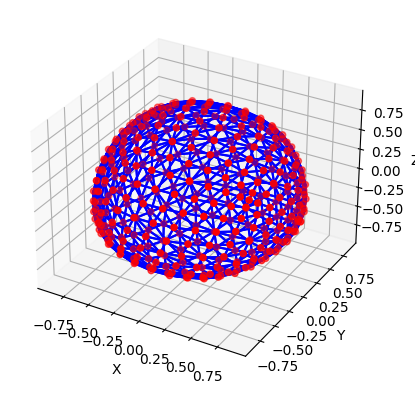

vertex set [[-1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [-1.  1.  1.]
 [ 1. -1. -1.]
 [ 1. -1.  1.]
 [ 1.  1. -1.]
 [ 1.  1.  1.]]
[-1. -1. -1.]
[-1.  1. -1.]
[-1.          0.33333333 -1.        ]
10
thumbs up
thumbs up
vertex set [[-1.          0.33333333 -1.        ]
 [-1.         -1.          1.        ]
 [-1.          1.          1.        ]
 [ 1.         -1.         -1.        ]
 [ 1.         -1.          1.        ]
 [ 1.          1.         -1.        ]
 [ 1.          1.          1.        ]]
[-1.  1.  1.]
[-1. -1.  1.]
[-1.         -0.33333333  1.        ]
8
Decimated Mesh Info: <trimesh.Trimesh(vertices.shape=(6, 3), faces.shape=(8, 3))>


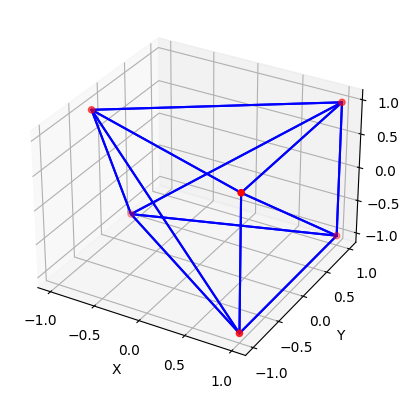

In [19]:

if __name__ == '__main__':
    # Load mesh and print information
    # mesh = trimesh.load_mesh('assets/cube.obj')
    # custom function to read .obj files
    # mesh = load('assets/cube.obj')
    # print("Vertices:", mesh.vertices)
    # print("Faces:", mesh.faces)

    mesh = trimesh.creation.box(extents=[2, 2, 2])
    print(f'Mesh Info: {mesh}')
    # print("Vertices:", mesh.vertices)
    # print("Faces:", mesh.faces)

    # apply loop subdivision over the loaded mesh
    # mesh_subdivided = mesh.subdivide_loop(iterations=2)

    # TODO: implement your own loop subdivision here
    mesh_subdivided = subdivision_loop(mesh, iterations=3)

    # print the new mesh information and save the mesh
    print(f'Subdivided Mesh Info: {mesh_subdivided}')
    # plot_mesh(mesh_subdivided_1.vertices, mesh_subdivided_1.faces)
    plot_mesh(mesh_subdivided.vertices, mesh_subdivided.faces)
    # mesh_subdivided.export('assets/assignment1/cube_subdivided.obj')
    # plot_original_and_subdivided_mesh(mesh, mesh_subdivided)

    # quadratic error mesh decimation
    # mesh_decimated = mesh.simplify_quadric_decimation(3)
    # print(mesh_decimated_1.vertices)

    # TODO: implement your own quadratic error mesh decimation here
    mesh_decimated = simplify_quadric_error(mesh, face_count=8,extra_credit=False)
    # print(mesh_decimated_1.vertices)
    # print(mesh_decimated.vertices)

    # print the new mesh information and save the mesh
    print(f'Decimated Mesh Info: {mesh_decimated}')
    # plot_mesh(mesh_decimated_1.vertices, mesh_decimated_1.faces)
    plot_mesh(mesh_decimated.vertices, mesh_decimated.faces)
    # mesh_decimated.export('assets/assignment1/cube_decimated.obj')